In [7]:
# Fist install the library

#%pip install aepy

In [8]:
import os
import sys

notebook_dir = os.path.abspath('')
sys.path.append(os.path.join(notebook_dir, '..'))

import numpy as np

from sklearn.metrics import accuracy_score
from keras import utils

from rapidae.data.datasets import load_MNIST
from rapidae.data.utils import evaluate, display_diff, add_noise
from rapidae.models.vq_vae.vq_vae_model import VQ_VAE
from rapidae.models.base.default_architectures import Encoder_Conv_VQ_MNIST, Decoder_Conv_VQ_MNIST
from rapidae.pipelines.training import TrainingPipeline

In [9]:
# Load MNIST dataset
x_train, y_train, x_test, y_test = load_MNIST(persistant=True)

# Obtaint number of clasess
n_classes = len(set(y_train))

# Convert labels to categorical
y_train = utils.to_categorical(y_train, n_classes)
y_test = utils.to_categorical(y_test, n_classes)

2023-12-20 20:06:32 [INFO]: train-images-idx3-ubyte.gz already exists.
2023-12-20 20:06:32 [INFO]: train-labels-idx1-ubyte.gz already exists.
2023-12-20 20:06:32 [INFO]: t10k-images-idx3-ubyte.gz already exists.
2023-12-20 20:06:32 [INFO]: t10k-labels-idx1-ubyte.gz already exists.


In [10]:
train_data = dict(data=x_train.astype(float), labels=x_train)
test_data = dict(data=x_test.astype(float), labels=y_test)

In [11]:
# Model creation
model = VQ_VAE(input_dim=(x_train.shape[1], x_train.shape[2]), 
            latent_dim=2, encoder=Encoder_Conv_VQ_MNIST, decoder=Decoder_Conv_VQ_MNIST, layers_conf=[32, 64])

model.jit_compile = False

In [12]:
pipe = TrainingPipeline(name='training_pipeline',
                        model=model, num_epochs=10)

trained_model = pipe(train_data)

2023-12-20 20:06:32 [INFO]: +++ training_pipeline +++
2023-12-20 20:06:32 [INFO]: Creating folder in ../output_dir/training_pipeline_2023-12-20_20-06-32


Epoch 1/10
(128, 7, 7, 2)
(128, 7, 7, 2)


/home/lucaspc/venvs/keras_core/lib/python3.11/site-packages/keras/src/layers/layer.py:358: UserWarning: `build()` was called on layer 'encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


(128, 7, 7, 2)


2023-12-20 20:06:33.863221: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


(96, 7, 7, 2)

Epoch 1: loss improved from inf to 1617.39478, saving model to ../output_dir/training_pipeline_2023-12-20_20-06-32/model.weights.h5
469/469 - 7s - 15ms/step - loss: 1617.3948 - reconstruction_loss: 1056.1034 - vq_loss: 561.2921
Epoch 2/10

Epoch 2: loss improved from 1617.39478 to 616.94519, saving model to ../output_dir/training_pipeline_2023-12-20_20-06-32/model.weights.h5
469/469 - 2s - 4ms/step - loss: 616.9452 - reconstruction_loss: 442.5461 - vq_loss: 174.3988
Epoch 3/10

Epoch 3: loss improved from 616.94519 to 504.73260, saving model to ../output_dir/training_pipeline_2023-12-20_20-06-32/model.weights.h5
469/469 - 2s - 5ms/step - loss: 504.7326 - reconstruction_loss: 384.9259 - vq_loss: 119.8069
Epoch 4/10

Epoch 4: loss improved from 504.73260 to 445.18887, saving model to ../output_dir/training_pipeline_2023-12-20_20-06-32/model.weights.h5
469/469 - 2s - 5ms/step - loss: 445.1889 - reconstruction_loss: 350.1984 - vq_loss: 94.9909
Epoch 5/10

Epoch 5: loss impro

In [13]:
import matplotlib.pyplot as plt

def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()

(9, 7, 7, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
[[[[ 4.84437048e-01]
   [-1.25137115e+00]
   [-1.03264280e-01]
   ...
   [-1.47486389e-01]
   [-2.90052354e-01]
   [-8.04783762e-01]]

  [[ 1.68314993e-01]
   [-3.95368040e-01]
   [ 7.75640070e-01]
   ...
   [-3.21930349e-01]
   [ 6.29520476e-01]
   [ 1.26188576e-01]]

  [[ 6.36542365e-02]
   [-9.30625856e-01]
   [ 7.27646887e-01]
   ...
   [-5.98874509e-01]
   [ 4.07842696e-01]
   [-1.34191370e+00]]

  ...

  [[-5.31510293e-01]
   [ 4.52391684e-01]
   [ 2.20281184e-01]
   ...
   [-1.28369272e-01]
   [ 7.27701247e-01]
   [-1.80186212e-01]]

  [[ 5.47785819e-01]
   [-9.89751294e-02]
   [ 2.07703173e-01]
   ...
   [-3.37069452e-01]
   [ 7.50005305e-01]
   [-2.99127996e-01]]

  [[ 3.47894728e-01]
   [ 2.46913493e-01]
   [ 2.02919066e-01]
   ...
   [-1.42131066e+00]
   [-9.97704446e-01]
   [ 3.97321653e+00]]]


 [[[ 4.84437048e-01]
   [-1.25137115e+00]
   [-1.03264280e-01]
   ...
   [-1.47486389e-01]
   [-2.90053308e-01]
   [-8.04783762e-

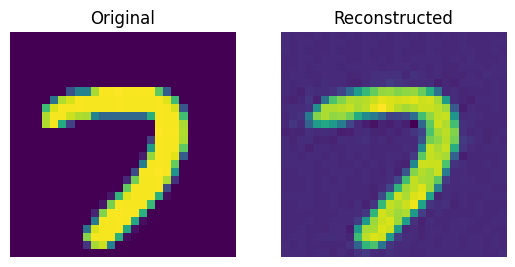

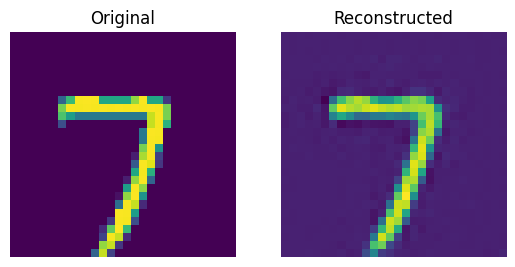

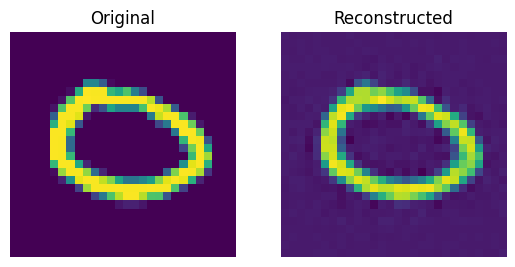

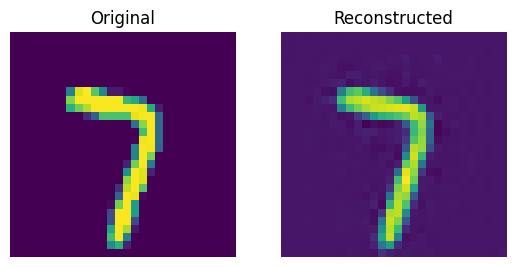

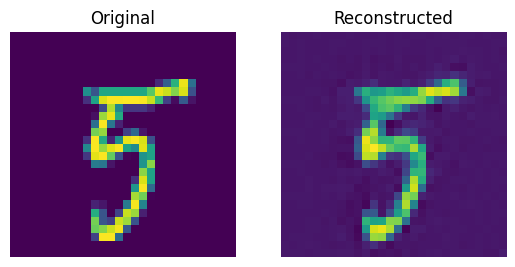

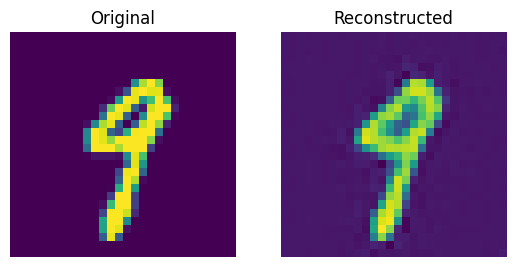

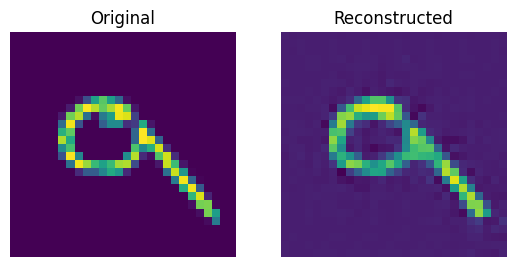

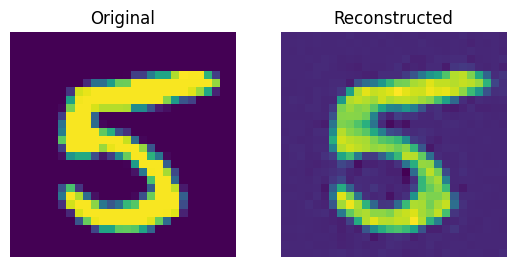

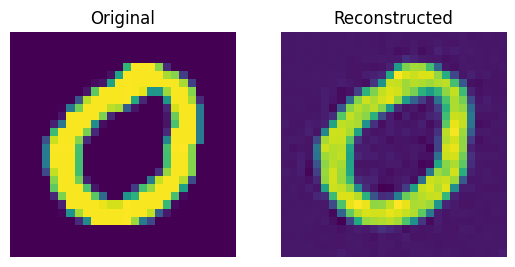

In [14]:
idx = np.random.choice(len(x_test), 9)

test_images = x_test[idx]
test_labels = y_test[idx]

#print(test_images.shape)
#print(test_labels.shape)

test_data = dict(data=test_images.astype(float), labels=test_labels)

reconstructions_test = trained_model.predict(test_data)

print(reconstructions_test['recon'])

for test_image, reconstructed_image in zip(test_images, reconstructions_test['recon']):
    show_subplot(test_image, reconstructed_image)